# Charging Stations at EPFL (GreenMotion dataset)

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
from datetime import *

In [146]:
DATA_FOLDER = 'data'

### A. Loading phase
Load the EPFL charging stations excel file into a `DataFrames`. 

In [147]:
cs_dataframe = pd.read_excel("{}/EPFL-data-extract.xlsx".format(DATA_FOLDER), index_col=0) 

In [213]:
cs_weather = pd.read_csv('{}/weather.csv'.format(DATA_FOLDER), index_col = None)

In [215]:
Cha = ['Year','Month','Day','Hour','TMP','WNDCHILL','DPT','WNDSPD','Humidity','PRMSL','RAIN']

In [216]:
cs_weather = cs_weather[Cha]

In [217]:
cs_weather['RAIN'] = cs_weather['RAIN'].apply(lambda x: float(x.split('/')[0]) if x != '--' else float(0))

In [219]:
cs_weather.head()

,Year,Month,Day,Hour,TMP,WNDCHILL,DPT,WNDSPD,Humidity,PRMSL,RAIN
0,2013,11,1,00:00,8.7,8.1,6.1,5.6,84,1024.2,0.0
1,2013,11,1,01:00,8.5,7.9,5.7,5.6,83,1023.9,0.0
2,2013,11,1,02:00,8.2,7.5,5.6,5.6,84,1023.6,0.0
3,2013,11,1,03:00,8.1,7.4,5.8,5.6,85,1023.3,0.0
4,2013,11,1,04:00,8.2,7.5,6,5.6,86,1022.9,0.0


In [220]:
len(cs_dataframe[cs_dataframe['HashedUserId'] == 'empty'])

8346

### B. Exploring the data

Useful functions:

In [221]:
def nb_minutes(EndDate, BeginDate):
    delta = EndDate - BeginDate
    nb_min_final_day = delta.seconds//60
    nb_days = delta.days
    nb_min = nb_min_final_day + nb_days*24*60 + 1
    return nb_min

Computing charging duration and power:

In [222]:
delta_vect = cs_dataframe.apply(lambda x : nb_minutes(x.EndDate, x.BeginDate), axis=1) #compute minutes of charge
cs_dataframe["ChargingDuration"] = delta_vect 
cs_dataframe["Power"] = cs_dataframe["PowerConsumption"] / cs_dataframe["ChargingDuration"] * 60 # compute power
#cs_df = cs_dataframe.drop('HashedUserId', axis=1)
cs_df = cs_dataframe
cs_df.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power
ChargeLogId,,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,0x725B61EAA9973F5EF7FE6BE2033C5F264982C8C04ED3...,1,0.0
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0


give each user_id one number for easily operation

In [223]:
Userlst = list(cs_df['HashedUserId'].unique()) 
Userlst.remove('empty')                # get all user_id except for NULL
User_num = range(1, len(Userlst)+1)

In [224]:
User_collect = dict(zip(Userlst, User_num))
User_collect['empty'] = 0           # give each user_id one numer which is easierly read than Hash value

In [225]:
cs_df['HashedUserId'] = cs_df['HashedUserId'].apply(lambda x: User_collect[x])

add weekday/weekend info

In [226]:
cs_df['weekday'] = cs_df['BeginDate'].apply(lambda x: x.weekday() + 1)

Let's remove unrealistic charging powers:

In [227]:
cs_df_clean = cs_df[cs_df.Power < 30000] # removing outliers (P>30kW...)

In [228]:
cs_df_clean.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power,weekday
ChargeLogId,,,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,1,1,0.0,5
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,2,1,0.0,5
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,2,1,0.0,5
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,2,1,0.0,5
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,2,1,0.0,5


In [229]:
cs_weather.head()

,Year,Month,Day,Hour,TMP,WNDCHILL,DPT,WNDSPD,Humidity,PRMSL,RAIN
0,2013,11,1,00:00,8.7,8.1,6.1,5.6,84,1024.2,0.0
1,2013,11,1,01:00,8.5,7.9,5.7,5.6,83,1023.9,0.0
2,2013,11,1,02:00,8.2,7.5,5.6,5.6,84,1023.6,0.0
3,2013,11,1,03:00,8.1,7.4,5.8,5.6,85,1023.3,0.0
4,2013,11,1,04:00,8.2,7.5,6,5.6,86,1022.9,0.0


###  join these two data set together

#### 1) At what time were built each stations? 

In [25]:
min_date = cs_df_clean.groupby('ChargingStationId').min().BeginDate
min_date

ChargingStationId
118    2013-11-22 09:02:37
577    2015-06-18 13:47:10
3391   2018-10-24 13:03:13
3392   2018-10-24 12:54:51
3398   2018-10-24 12:50:27
3399   2018-10-24 12:44:34
3413   2019-06-19 08:14:33
3461   2019-05-24 13:10:39
4743   2019-01-22 14:23:54
4744   2019-01-22 14:16:46
4745   2019-01-23 08:05:05
Name: BeginDate, dtype: datetime64[ns]

#### 2) What is the charging power of each station? 

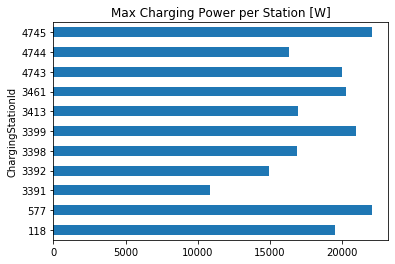

In [26]:
#compute mximum charging power
max_pow = cs_df_clean.groupby('ChargingStationId').max().Power.astype(int)
max_pow.plot(kind='barh', title='Max Charging Power per Station [W]')

Apart from station 3391, all other stations seem to be able to charge above 11kW and below 22kW. 

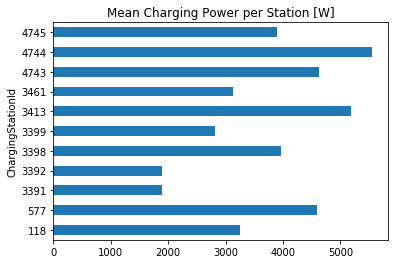

In [27]:
#compute average charging power
avg_pow = cs_df_clean.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow.plot(kind='barh', title='Mean Charging Power per Station [W]')

Most efficient charging stations seem to be **4744** and **3413** (P>5kW).   
Less efficient ones seem to be **3392** and **3391** (P<2kW).

In [48]:
datetime.now().day

14

#### 3) behavior pattern for User_Id and Null

In [28]:
from datetime import datetime

In [102]:
cs_03_02_08 = cs_df_clean[cs_df_clean.BeginDate.dt.week == 12] # data from 2020-03-02 to 2020-03-08

In [103]:
df_03_new = cs_03_02_08
df_03_new.BeginDate = cs_03_02_08.BeginDate.dt.hour
df_03_new.EndDate = cs_03_02_08.EndDate.dt.hour +1

distrib = np.zeros(24)
for i in df_03_new[df_03_new['HashedUserId'] != 0].index:
    for h in range(df_03_new.loc[i].BeginDate.astype(int), df_03_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_03_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

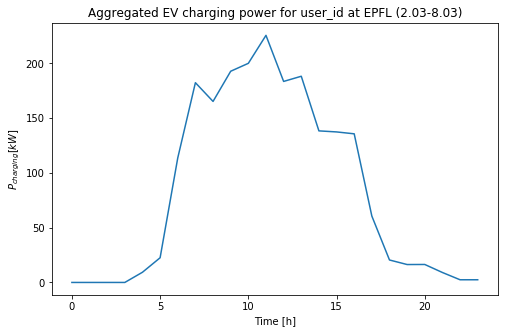

In [104]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power for user_id at EPFL (2.03-8.03)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

In [105]:

distrib = np.zeros(24)
for i in df_03_new[df_03_new['HashedUserId'] == 0].index:
    for h in range(df_03_new.loc[i].BeginDate.astype(int), df_03_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_03_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

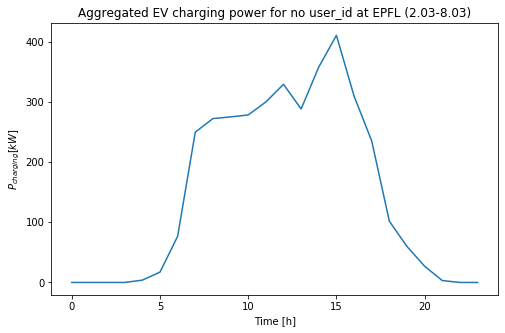

In [106]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power for no user_id at EPFL (2.03-8.03)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

It seems that the users who don't have a userid will consume more power in afternoon.

#### 4) charging number for weekdays and weekends

In [137]:
df_day = cs_df_clean

In [138]:
df_day['week'] = df_day['BeginDate'].apply(lambda x: x.strftime("%W"))
df_day['year'] = df_day['BeginDate'].apply(lambda x: x.strftime("%Y"))

In [144]:
df_day.groupby(['year','week','weekday']).Power.sum().sort_values(ascending = False)

year  week  weekday
2019  40    4          198544.617961
      43    5          187761.310081
      40    1          181124.198767
      09    4          169999.471547
      39    2          156273.867361
                           ...      
2017  52    2               0.000000
2016  01    7               0.000000
2017  08    7               0.000000
2013  50    2               0.000000
2016  25    7               0.000000
Name: Power, Length: 2081, dtype: float64

### C) Charging power profile on 09/03/2020

In [34]:
#focusing data on 09/03/2020
df_20_03_09_begin = cs_df_clean[cs_df_clean.BeginDate.dt.date == date(2020, 3, 9)]
df_20_03_09 = df_20_03_09_begin[df_20_03_09_begin.EndDate.dt.date == date(2020, 3, 9)]
df_20_03_09.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power,weekday
ChargeLogId,,,,,,,,,
711743,3392,4402,2020-03-09 12:49:43,2020-03-09 16:18:38,7650,178,209,2196.172249,1
711097,3413,4440,2020-03-09 05:13:41,2020-03-09 06:58:28,16805,253,105,9602.857143,1
711135,4745,5836,2020-03-09 05:33:25,2020-03-09 07:39:02,6578,255,126,3132.380952,1
711156,4743,5834,2020-03-09 07:58:24,2020-03-09 08:05:59,856,326,8,6420.000000,1
711399,3399,4409,2020-03-09 07:27:21,2020-03-09 11:56:52,8118,180,270,1804.000000,1


#### 1) Charging Power per Station

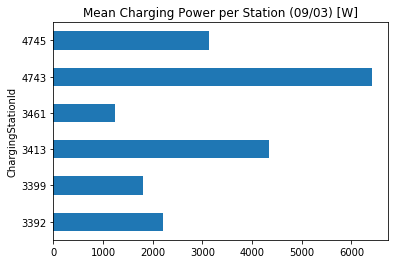

In [35]:
avg_pow_2020 = df_20_03_09.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow_2020.plot(kind='barh', title='Mean Charging Power per Station (09/03) [W]')

#### 2) Creating hourly distribution

In [36]:
df_2020_new = df_20_03_09
df_2020_new.BeginDate = df_20_03_09.BeginDate.dt.hour
df_2020_new.EndDate = df_20_03_09.EndDate.dt.hour +1

distrib = np.zeros(24)
for i in df_2020_new.index:
    for h in range(df_2020_new.loc[i].BeginDate.astype(int), df_2020_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_2020_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

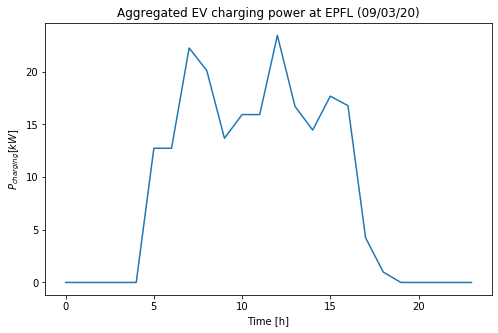

In [37]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power at EPFL (09/03/20)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')
